# Step 1: Show Images and Captions

Caption: a photo of a sks dog standing on the grass


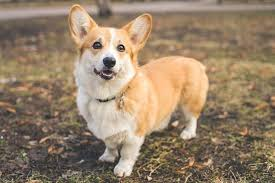

Caption: a photo of a sks dog jumping on the grass


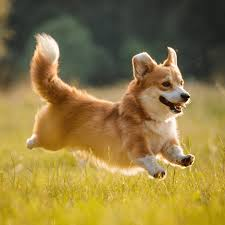

Caption: a photo of a sks dog sitting on the floor


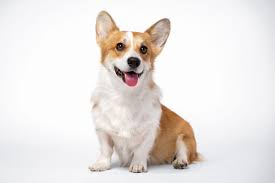

Caption: a photo of a sks dog  in front of a wall


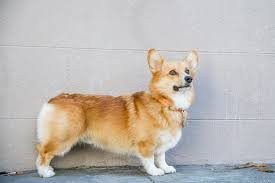

Caption: a photo of a sks dog with its tongue out


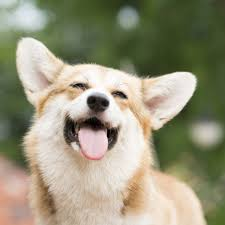

In [33]:
import os
from IPython.display import display, Image

# Dataset directory
DATASET_DIR = "dog_dataset"

# Load image-caption pairs
image_caption_pairs = []
for fname in sorted(os.listdir(DATASET_DIR)):
    if fname.endswith(".jpg"):
        txt_file = fname.replace(".jpg", ".txt")
        txt_path = os.path.join(DATASET_DIR, txt_file)
        with open(txt_path, "r") as f:
            caption = f.read().strip()
        image_caption_pairs.append((fname, caption))

# Show all pairs
for img, caption in image_caption_pairs:
    print(f"Caption: {caption}")
    display(Image(filename=os.path.join(DATASET_DIR, img)))

# Step 2: Fine-tune Stable Diffusion 1.5 using DreamBooth + LoRA

In [ ]:
# Launch training with accelerate (log will show progress)
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path=runwayml/stable-diffusion-v1-5 \
  --instance_data_dir=dog_dataset \
  --output_dir=dog_lora_model \
  --instance_prompt="a photo of a sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --checkpointing_steps=100 \
  --max_train_steps=800 \
  --seed=42

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/home/vene/DGM_env/lib/python3.10/site-packages/accelerate/accelerator.py:506: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
05/11/2025 18:13:23 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'clip_sample_r

# Step 3: Load the fine-tuned model, perform inference and generate images

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt



Loading the fine-tuned model

In [3]:
base_model = "runwayml/stable-diffusion-v1-5"
lora_path = "dog_lora_model"

pipe = StableDiffusionPipeline.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    safety_checker=None,
    variant="fp16"
).to("cuda")

# load LoRA weights
pipe.load_lora_weights(lora_path)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 26.78it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue i


Define picture generation and display functions

In [4]:
def generate_images(prompts, num_inference_steps=30, guidance_scale=7.5):
    images = []
    for prompt in prompts:
        image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        images.append((prompt, image))
    return images

def show_images(images):
    plt.figure(figsize=(15, 10))
    for i, (prompt, img) in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(prompt, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()



Test the Prompt and show the picture

100%|██████████| 30/30 [00:02<00:00, 11.61it/s]


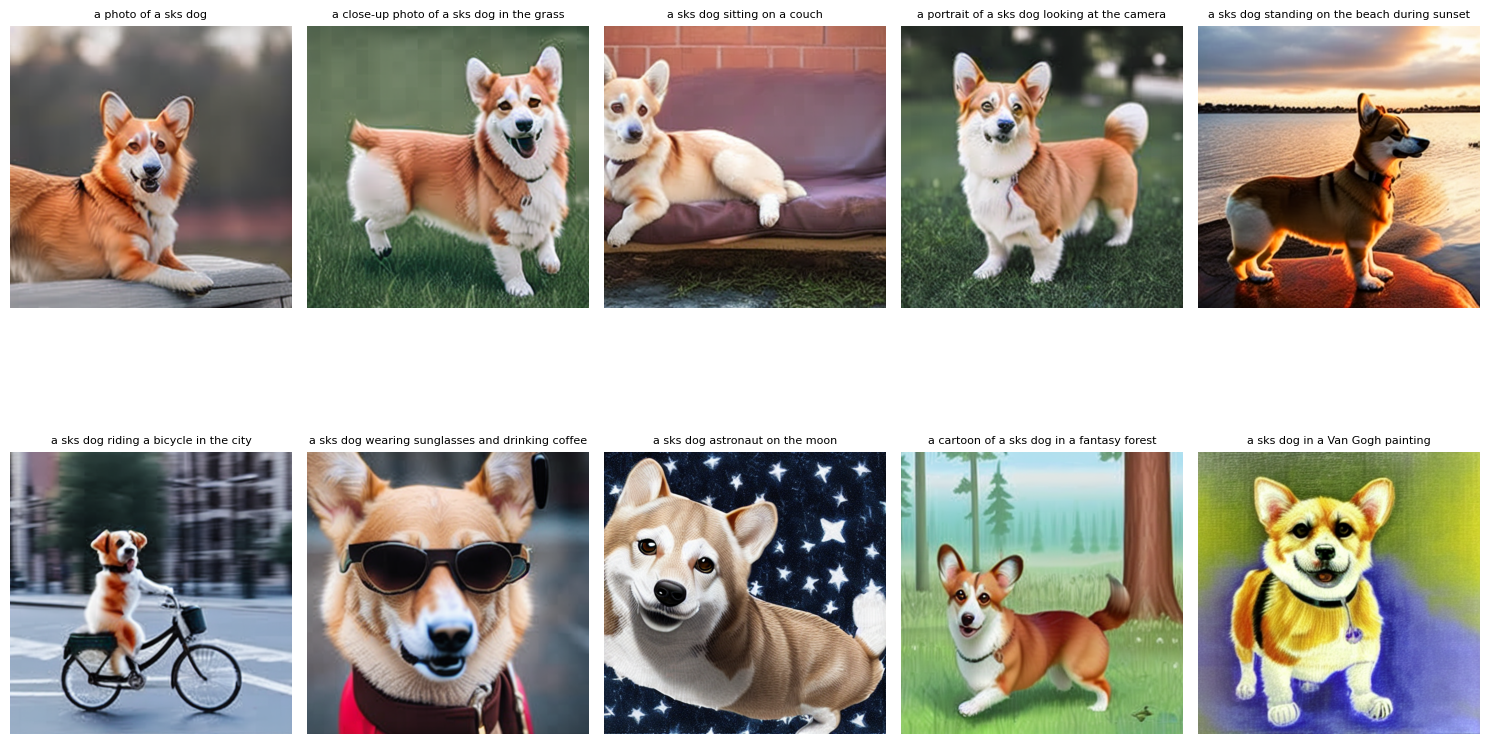

In [5]:
prompts = [
    # Common prompts during training
    "a photo of a sks dog",
    "a close-up photo of a sks dog in the grass",
    "a sks dog sitting on a couch",
    "a portrait of a sks dog looking at the camera",
    "a sks dog standing on the beach during sunset",

    # Creative new prompt (test generalization ability)
    "a sks dog riding a bicycle in the city",
    "a sks dog wearing sunglasses and drinking coffee",
    "a sks dog astronaut on the moon",
    "a cartoon of a sks dog in a fantasy forest",
    "a sks dog in a Van Gogh painting"
]

images = generate_images(prompts)
show_images(images)
